<a href="https://colab.research.google.com/github/bborisggg/hw_econometrics/blob/main/hw_econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!rm -rf hw_econometrics

In [120]:
!git clone https://github.com/bborisggg/hw_econometrics

Cloning into 'hw_econometrics'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (41/41), 364.25 KiB | 12.14 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [121]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [122]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries, maxlag='auto', regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Опираемся на одну из возможных спецификаций модели:

https://doi.org/10.1108/IJOEM-10-2018-0551

Берем из статьи набор переменных

$$X_t = (\Delta oilp_t ; ygap_t ; \Delta ms_t ; \Delta ir_t ; \Delta er_t; \Delta cpi_t)'$$

Отсюда берем данные по цене на нефть марки Brent
https://fred.stlouisfed.org/series/MCOILBRENTEU

<Axes: xlabel='date'>

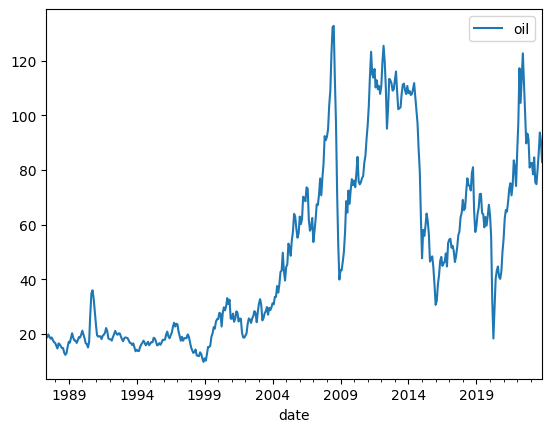

In [123]:
oil = pd.read_excel('hw_econometrics/data/MCOILBRENTEU.xls',skiprows=10)
oil = oil.rename(columns={'observation_date':'date','MCOILBRENTEU':'oil'})
oil = oil.set_index('date')
oil.index = pd.PeriodIndex(oil.index, freq='M')
oil.plot()

<Axes: xlabel='date'>

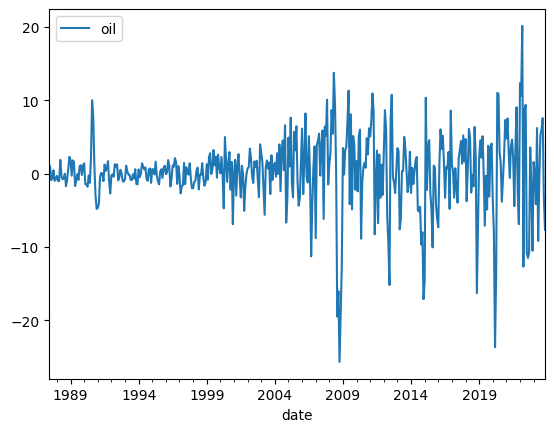

In [124]:
d_oil = oil.diff().iloc[1:]
d_oil.plot()

In [125]:
adf_test(d_oil, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.490933e+01
p-value                        1.466550e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


Можем считать, что ряд стационарен

Ряд разрыва выпуска можем получить из данных по индексу промышленного производства Росстата
Источник:
https://fedstat.ru/indicator/43046
https://fedstat.ru/indicator/57806

<Axes: xlabel='date'>

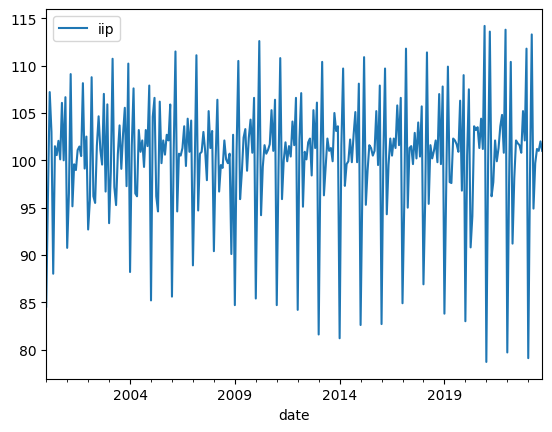

In [126]:
iip = pd.read_excel('hw_econometrics/data/iip_russia.xlsx')
iip = iip.set_index('date')
iip.index = pd.PeriodIndex(iip.index, freq='M')
iip.plot()

У нас есть цепной индекс изменений. Хотим перейти к базисному индексу

In [127]:
iip = (iip/100).cumprod()

In [128]:
prev_index = iip.index
iip.index = iip.index.strftime('%Y-%m-%d')

In [129]:
iip.to_excel('iip_unadjusted.xlsx')

Скачиваем отредактированный файл:

<Axes: xlabel='date'>

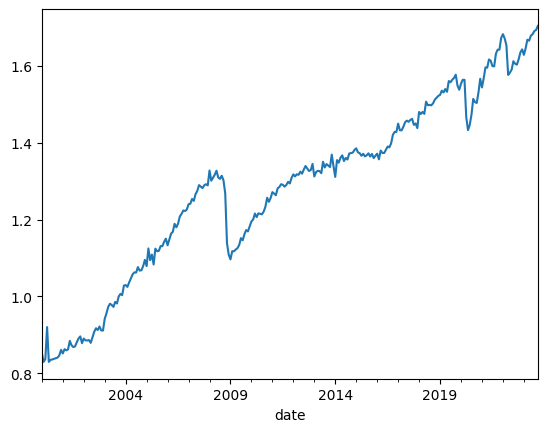

In [130]:
iip = pd.read_excel('hw_econometrics/data/iip_adjusted.xlsx')
iip.index = prev_index
iip = iip['adjusted']
iip.plot()

<Axes: xlabel='date'>

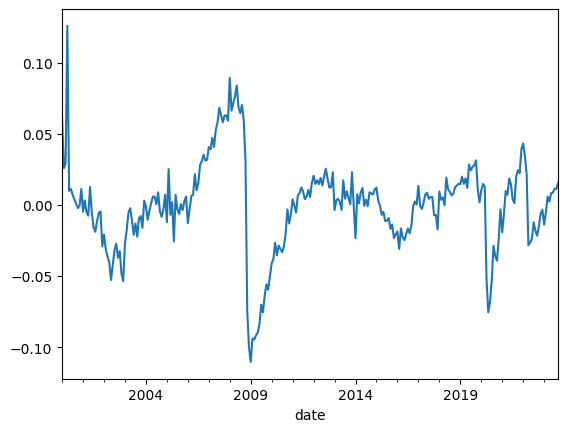

In [131]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(iip, lamb = 129600)
ygap = cycle / trend
ygap.plot()

In [132]:
adf_test(ygap, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                  -4.560716
p-value                          0.000153
#Lags Used                       0.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


Теперь переходим к монетарной переменной, предложению денег в России. Данные по агрегату M2 предоставляет Банк России.

https://www.cbr.ru/statistics/ms/

In [168]:
ms = pd.read_excel('hw_econometrics/data/monetary_agg.xlsx')
ms = pd.DataFrame({'date':ms.columns[1:],'ms':ms.iloc[12].to_numpy()[1:].astype('float')})
ms = ms.set_index('date')
ms.index = pd.PeriodIndex(ms.index, freq='M')

In [172]:
for_export = ms.copy()
for_export.index = for_export.index.strftime('%Y-%m-%d')
for_export.to_excel('ms_unadjusted.xlsx')

In [166]:
adf_test(ms.diff().iloc[1:], maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                  -0.124067
p-value                          0.946988
#Lags Used                      12.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64
